In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = 'cpu'

In [3]:
# Hyperparameters

num_epochs = 4
batch_size = 4
lr = 1e-3

In [4]:
# transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# data loaders

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
examples = iter(train_loader)
imgs = next(examples)[0]
imgs.shape

torch.Size([4, 3, 32, 32])

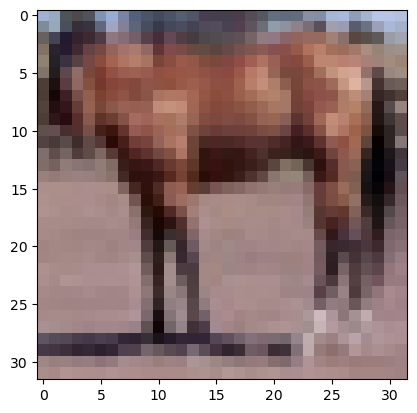

In [6]:
plt.imshow(imgs[0].permute(1, 2, 0) / 2 + 0.5)

In [7]:
class ConvNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [8]:
num_batches = len(train_loader)
num_batches

12500

In [9]:
for epoch in range(num_epochs):
    history = torch.empty([2,0])
    for i, (images, labels) in enumerate(train_loader):
        output = model(images)
        
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{num_batches}, Loss {loss:.4f}')
            history = torch.cat([history, torch.tensor([i + epoch*num_batches, loss]).reshape(2, 1)], dim=1)
        
    torch.save(history, 'model_history.pt')
        

Epoch 1/4, Step 1000/12500, Loss 2.3313
Epoch 1/4, Step 2000/12500, Loss 2.3135
Epoch 1/4, Step 3000/12500, Loss 2.2817
Epoch 1/4, Step 4000/12500, Loss 2.3018
Epoch 1/4, Step 5000/12500, Loss 2.2948
Epoch 1/4, Step 6000/12500, Loss 2.2865
Epoch 1/4, Step 7000/12500, Loss 2.3085
Epoch 1/4, Step 8000/12500, Loss 2.3005
Epoch 1/4, Step 9000/12500, Loss 2.1256
Epoch 1/4, Step 10000/12500, Loss 2.2861
Epoch 1/4, Step 11000/12500, Loss 2.2480
Epoch 1/4, Step 12000/12500, Loss 1.8523
Epoch 2/4, Step 1000/12500, Loss 1.8777
Epoch 2/4, Step 2000/12500, Loss 1.7798
Epoch 2/4, Step 3000/12500, Loss 1.8347
Epoch 2/4, Step 4000/12500, Loss 1.7858
Epoch 2/4, Step 5000/12500, Loss 1.8616
Epoch 2/4, Step 6000/12500, Loss 1.7889
Epoch 2/4, Step 7000/12500, Loss 1.7005
Epoch 2/4, Step 8000/12500, Loss 1.6271
Epoch 2/4, Step 9000/12500, Loss 1.6588
Epoch 2/4, Step 10000/12500, Loss 1.2215
Epoch 2/4, Step 11000/12500, Loss 1.3442
Epoch 2/4, Step 12000/12500, Loss 1.9103
Epoch 3/4, Step 1000/12500, Loss 1

In [10]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            
    acc = 100.0 * n_correct / n_samples
    print(acc)
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{i}: {acc}%')

46.11
0: 54.7%
1: 58.8%
2: 11.2%
3: 14.6%
4: 30.7%
5: 48.8%
6: 70.9%
7: 61.0%
8: 53.4%
9: 57.0%
